<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_2_Scripted_Product_Access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

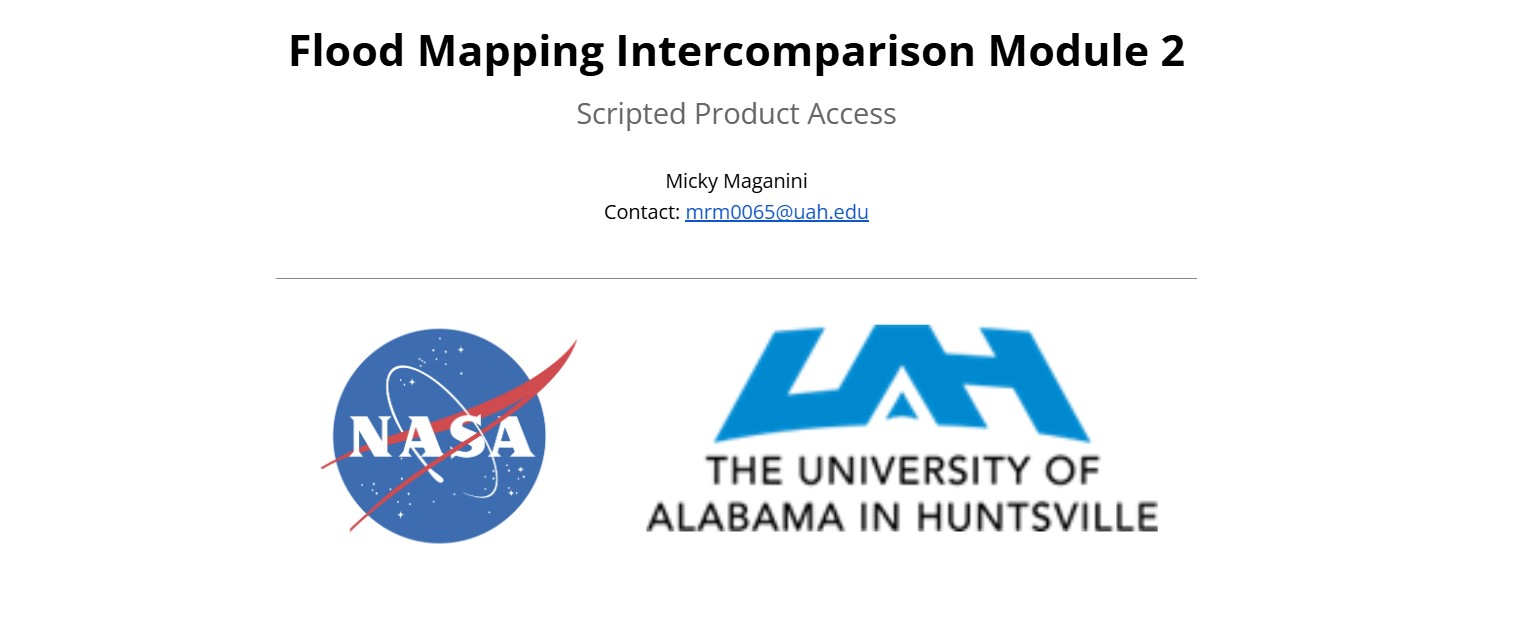

# Introduction

In this module, we will get access to the following flood products:

In this module, we will obtain some open source flood products and upload them to Google Earth Engine. We will be grabbing the following flood products:
1. MCDWD -- MODIS Combined Water Detection Product (NRT MODIS/Aqua+Terra Global Flood Product MCDWD_L3_NRT, Slayback et al 2023)
2. VIIRS Flood Mapping Product -- (Li et al 2017)
3. Copernicus Global Flood Monitor  (Salamon et al 2021)
4. DSWX-HLS -- Observational Products for End User Analysis Dynamic Surface Water Extent (DSWx) from the Harmonized Landsat-Sentinel (HLS) Satellite Data. (OPERA 2023)
5. DSWx-S1 -- Observational Products for End User Analysis Dynamic Surface Water Extent (DSWx) from the Sentinel-1 (S1) Satellite Data
6. HYDRAFloods -- HYDRologic Remote Sensing Analysis for FLOODS.
7. HYDROSAR

This document contains a brief summary of each product. For a more detailed look at the characteristics of each dataset, click [this link](https://github.com/SERVIR/flood_mapping_intercomparison/blob/main/resources/Flood_Product_Specifications.pdf) to view a spreadhseet with more details.

### **IMPORTANT**

To access the DSWX-HLS products and run HYDROSAR, you will need a NASA Earthdata account .
 * If you do not have one, you can register [here](https://urs.earthdata.nasa.gov/users/new) free of charge
 * If you do have a NASA Earthdata account, you can login [here](https://urs.earthdata.nasa.gov/home) to double-check that your credentialS

To access the GFM product, you will need a GFM account

* If you do not have a GFM account, you can register [here](https://portal.gfm.eodc.eu/register) free of charge.
* If you do have  a GFM account, you can login [here](https://portal.gfm.eodc.eu/login?redirect=%5Bobject%20Object%5D) to double-check your credentials.

### **MODIFIABLE VARIABLE ALERT**

Declare some of your global variables below.

In [ ]:
my_earthdata_login = "################"                                     # Replace with your earthdata login (email adress) in string format
my_earthdata_password = "#############"                                     # Replace with your earthdata password in string format
my_gfm_email = "################"                                           # Replace with your GFM login (email adress) in string format
my_gfm_password = "####################"                                          # Replace with your GFM password in string format

my_gee_folder = "users/mickymags/sep_cambodia/"               # Make sure this ends in a slash
my_gee_project = "servir-sco-assets"
my_Gdrive_folder = 'drive/MyDrive/Flood_Intercomparison/Case_Studies/sep/sep_cambodia/'   # Make sure this ends in a slash
my_start_date = "2024-10-01"
flood_event_desc = 'sep_cambodia'

# Step 0: Take care of some housekeeping matters

Before we start requesting some data, we need to do a couple of things

1. Create a .netrc file.
  * A .netrc file allows us to mimic the login process we would do when we sign into a website such as NASA Earthdata to download data. Usually this would be a file that exists in our home directory, but since we are working in Google Colaboratory, we can do this programatically
2. Install and import various packages we will use throughout the rest of the notebook
3. Define the bounding box based on the area of interest we have in Google Earth Engine
4. Mount Google Drive

## Step 0 Part 1: Create the .netrc file

In [ ]:
my_netrc_string = "machine urs.earthdata.nasa.gov login " + my_earthdata_login + " password " + my_earthdata_password

Credit to user jruss on stackoverflow.com for the piece of code below, see [this post](https://stackoverflow.com/questions/67153514/use-request-with-nasa-data-on-google-colaboratory)

In [ ]:
# Setup NASA
!touch /root/.netrc
!echo $my_netrc_string >/root/.netrc
!chmod 0600 /root/.netrc

# Step 0 Part 2: Install and Import Relevant Python Packages

In [ ]:
!pip install boto3                                     # Install boto3
!pip install earthaccess                               # Install earthaccess
!pip install ipyleaflet==0.18.2 geemap hydrafloods     # Install hydrafloods and its relevant dependencies
!pip install hydrosar asf_tools hyp3_sdk               # Install hydrosar and its relevant dependencies
!pip install geemap
!pip install opensarlab_lib

Import relevant packages below

In [ ]:
from google.colab import drive
from osgeo import gdal
import earthaccess
import os
import subprocess
import glob
from osgeo import gdal
import ee
import boto3
from botocore.client import Config
from botocore import UNSIGNED
import requests
import shutil
import hyp3_sdk as sdk
from hydrosar.water_map import make_water_map
from hydrafloods import corrections
import hydrafloods as hf
import geemap
import numpy as np
import zipfile
import opensarlab_lib as osl
import time

###**IMPORTANT**
If you get an error that "no such package exists" for the above cell, don't worry! We just need to install the gdal package within Google Colab.

If you got this error, Uncomment and run the relevant code cell(s) below, then run the code cell above again to complete the import process

If you did not get this error, proceed to step 0 part 4

In [ ]:
'''
################################################################################
# INSTALL GDAL ON GOOGLE COLAB
################################################################################
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

!conda install -c conda-forge gdal
'''

Thank you and credit to Dr. Chanin Nantasenamat and his "Data Professor" Youtube Channel for the above code: [https://github.com/dataprofessor](https://github.com/dataprofessor)

# Step 0 part 3: Define bounding box from AOI

In [ ]:
# Authenticate and initialize earthengine
ee.Authenticate()
ee.Initialize(project = my_gee_project)

In [ ]:
my_aoi = ee.FeatureCollection(my_gee_folder + "aoi")
coords = my_aoi.bounds().getInfo()['coordinates']
lon_min = coords[0][0][0]
lat_min = coords[0][0][1]
lon_max = coords[0][2][0]
lat_max = coords[0][2][1]

Get day after

In [ ]:
myeedate = ee.Date(my_start_date)
my_ee_dayafter = myeedate.advance(1, 'day')

In [ ]:
mydayafter_year = str(my_ee_dayafter.get('year').getInfo())
mydayafter_month = my_ee_dayafter.get('month').getInfo()

if mydayafter_month < 10:
  monthstr = '0' + str(mydayafter_month)
else:
  monthstr = str(mydayafter_month)


mydayafter_day = my_ee_dayafter.get('day').getInfo()

if mydayafter_day < 10:
  datestr = '0' + str(mydayafter_day)
else:
  datestr = str(mydayafter_day)

myday_after = mydayafter_year + "-" + monthstr + '-' + datestr

# Step 0 part 4: Mount Google Drive

In [ ]:
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/

In [ ]:
pwd

In [ ]:
gdrive_split = my_Gdrive_folder.split('/')[2:-1]
gdrive_split

for i in gdrive_split:
  stri = str(i)
  if os.path.isdir(stri) == True:      #if folder already exists, enter into it
    os.chdir(stri)
  else:                                # if folder doeesn't yet exist, create it, then enter it.
    os.mkdir(stri)
    os.chdir(stri)

# Part 1: DSWx-HLS

In [ ]:
ls

In [ ]:
auth = earthaccess.login(strategy="netrc")

In [ ]:
dswx_results = earthaccess.search_data(short_name="OPERA_L3_DSWX-HLS_V1",cloud_hosted=True,
                                     temporal=(my_start_date,my_start_date), bounding_box=(lon_min,lat_min,lon_max,lat_max))

In [ ]:
downloaded = earthaccess.download(dswx_results, local_path = 'dswx_hls')

In [ ]:
pwd

In [ ]:
cd dswx_hls

In [ ]:
ls

We want to extract only the files that end in "B02_BWTR.tif", as these are the binary water maps for each string. We can make a list of just these scenes using the glob method

In [ ]:
# Note that the 'S2A portion of the string below may need to change depending on if the HLS image is derived from a Sentinel-2 image or a Landsat-8 image'
dswxhls_list = glob.glob("OPERA_L3_DSWx-HLS*B01*.tif")

In [ ]:
pwd

In [ ]:
ls

In [ ]:
dswxhls_list

In [ ]:
info = gdal.Info(dswxhls_list[0])                                    # Extract the info from the first file in the list
projection_info_index = info.find('EPSG",32')                        # Find the projection of the file. We know they use the UTM projection which uses the EPSG code 32XXX, where XXX relates to the specific UTM zone
theproj = info[projection_info_index:projection_info_index + 12]     # slice the string to extract the substring containing the UTM projection
final_proj_string = theproj[0:4] + ':' + theproj[6:11]               # reformat the string into the projection format GDAL requires for us to reproject our imagery/

In [ ]:
print(final_proj_string)

In [ ]:
# Create a list of output files

new_dswxhls_names = []
num_dswxhls_scenes = len(dswxhls_list)
for j in range(num_dswxhls_scenes):
  if j < 9:
    dswxhls_string = "dswxhls_pt0" + str(j+1) + ".tif"
  else:
    dswxhls_string = "dswxhls_pt" + str(j+1) + ".tif"

  new_dswxhls_names.append(dswxhls_string)

In [ ]:
for k in range(num_dswxhls_scenes):
  outfile_name = new_dswxhls_names[k]
  infile_name = dswxhls_list[k]
  gdal.Warp(outfile_name, infile_name, dstSRS = final_proj_string)

In [ ]:
dswxhls_warped_list = glob.glob("dswxhls_pt[0-9][0-9].tif")

if len(dswxhls_warped_list) > 0:
  if len(dswxhls_warped_list) == 1:
    print('path2')
    os.rename(dswxhls_warped_list[0], 'merged_dswxhls_' + flood_event_desc + '.tif')
  else:
    print('path1')
    #vfm_warped_list = glob.glob("_reproj_pt[0-9].tif")
    cmd_dswxhls = "gdal_merge.py -o merged_dswxhls_" + flood_event_desc + ".tif"
    subprocess.call(cmd_dswxhls.split()+dswxhls_warped_list)
else:
    print('path3')
    print("No entries in dswxhls_warped_list. Something went wrong.")

# **Part 2: DSWx-S1**

In [ ]:
my_start_date

In [ ]:
myday_after

In [ ]:
os.chdir('..')                                           # Return to the parent folder

In [ ]:
dswxs1_results = earthaccess.search_data(short_name="OPERA_L3_DSWX-S1_V1",cloud_hosted=True,
                                     temporal=(my_start_date, my_start_date), bounding_box=(lon_min,lat_min,lon_max,lat_max))

In [ ]:
dswxs1_downloaded = earthaccess.download(dswxs1_results, local_path = 'dswxs1')

In [ ]:
os.chdir('dswxs1')

In [ ]:
dswxs1_list = glob.glob("OPERA_L3_DSWx-S1*_B02*.tif")

In [ ]:
# Create a list of output files

new_dswxs1_names = []
num_dswxs1_scenes = len(dswxs1_list)
for i in range(num_dswxs1_scenes):
  if i < 9:
    dswxs1_string = "dswxs1_pt0" + str(i+1) + ".tif"
  else:
    dswxs1_string = "dswxs1_pt" + str(i+1) + ".tif"

  infile = dswxs1_list[i]

  gdal.Warp(dswxs1_string, infile, dstSRS = final_proj_string)

In [ ]:
dswxs1_warped_list = glob.glob("dswxs1_pt[0-9][0-9].tif")

if len(dswxs1_warped_list) > 0:
  if len(dswxs1_warped_list) == 1:
    print('path2')
    os.rename(dswxs1_warped_list[0], 'merged_dswxs1_' + flood_event_desc + '.tif')
  else:
    print('path1')
    cmd_dswxs1 = "gdal_merge.py -o merged_dswxs1_" + flood_event_desc + ".tif"
    subprocess.call(cmd_dswxs1.split()+dswxs1_warped_list)
else:
    print('path3')
    print("No entries in dswxs1_warped_list. Something went wrong.")

In [ ]:
ls m*

# Part 3: VFM

Initialize the AWS client. The credentials for this are blank because the AWS bucket we are pulling from is public.

In [ ]:
cred = {
    "aws_access_key_id": "",
    "aws_secret_access_key": "",
    "config": Config(signature_version = UNSIGNED)
}

session = boto3.Session()
client = session.client('s3', **cred)

VFM divides its tiles into 15 degree by 15 degree tiles

In [ ]:
def vfm_tile_reporter(lon, lat):
  if lat > 75:
    if lon > 90 and lon < 105:
      vfm_tile = 50
    if lon > 105 and lon < 120:
      vfm_tile = 51
  if lat > 60 and lat < 75:
    if lon < -165:
      vfm_tile = 1
    if lon > -165 and lon < -150:
      vfm_tile = 2
    if lon > -150 and lon < -135:
      vfm_tile = 3
    if lon > -135 and lon < -120:
      vfm_tile = 4
    if lon > -120 and lon < -105:
      vfm_tile = 5
    if lon > -105 and lon < -90:
      vfm_tile = 6
    if lon > -90 and lon < -75:
      vfm_tile = 7
    if lon > -75 and lon < -60:
      vfm_tile = 8
    if lon > -60 and lon < -45:
      vfm_tile = 130
    if lon > -45 and lon < -30:
      vfm_tile = 131
    if lon > -30 and lon < -15:
      vfm_tile = 132
    if lon > -15 and lon < 0:
      vfm_tile = 42
    if lon > 0 and lon < 15:
      vfm_tile = 43
    if lon > 15 and lon < 30:
      vfm_tile = 44
    if lon > 30 and lon < 45:
      vfm_tile = 45
    if lon > 45 and lon < 60:
      vfm_tile = 46
    if lon > 60 and lon < 75:
      vfm_tile = 47
    if lon > 75 and lon < 90:
      vfm_tile = 48
    if lon > 90 and lon < 105:
      vfm_tile = 49
    if lon > 105 and lon < 120:
      vfm_tile = 52
    if lon > 120 and lon < 135:
      vfm_tile = 53
    if lon > 135 and lon < 150:
      vfm_tile = 54
    if lon > 150 and lon < 165:
      vfm_tile = 55
    if lon > 165 and lon < 180:
      vfm_tile = 56
  if lat > 45 and lat < 60:
    if lon < -165:
      vfm_tile = 9
    if lon > -165 and lon < -150:
      vfm_tile = 10
    if lon > -150 and lon < -135:
      vfm_tile = 129
    if lon > -135 and lon < -120:
      vfm_tile = 11
    if lon > -120 and lon < -105:
      vfm_tile = 12
    if lon > -105 and lon < -90:
      vfm_tile = 13
    if lon > -90 and lon < -75:
      vfm_tile = 14
    if lon > -75 and lon < -60:
      vfm_tile = 15
    if lon > -60 and lon < -45:
      vfm_tile = 16
    if lon > -15 and lon < 0:
      vfm_tile = 57
    if lon > 0 and lon < 15:
      vfm_tile = 58
    if lon > 15 and lon < 30:
      vfm_tile = 59
    if lon > 30 and lon < 45:
      vfm_tile = 60
    if lon > 45 and lon < 60:
      vfm_tile = 61
    if lon > 60 and lon < 75:
      vfm_tile = 62
    if lon > 75 and lon < 90:
      vfm_tile = 63
    if lon > 90 and lon < 105:
      vfm_tile = 64
    if lon > 105 and lon < 120:
      vfm_tile = 65
    if lon > 120 and lon < 135:
      vfm_tile = 66
    if lon > 135 and lon < 150:
      vfm_tile = 67
    if lon > 150 and lon < 165:
      vfm_tile = 68
    if lon > 165 and lon < 180:
      vfm_tile = 69
  if lat > 30 and lat < 45:
    if lon > -135 and lon < -120:
      vfm_tile = 17
    if lon > -120 and lon < -105:
      vfm_tile = 18
    if lon > -105 and lon < -90:
      vfm_tile = 19
    if lon > -90 and lon < -75:
      vfm_tile = 20
    if lon > -75 and lon < -60:
      vfm_tile = 21
    if lon > -15 and lon < 0:
      vfm_tile = 70
    if lon > 0 and lon < 15:
      vfm_tile = 71
    if lon > 15 and lon < 30:
      vfm_tile = 72
    if lon > 30 and lon < 45:
      vfm_tile = 73
    if lon > 45 and lon < 60:
      vfm_tile = 74
    if lon > 60 and lon < 75:
      vfm_tile = 75
    if lon > 75 and lon < 90:
      vfm_tile = 76
    if lon > 90 and lon < 105:
      vfm_tile = 77
    if lon > 105 and lon < 120:
      vfm_tile = 78
    if lon > 120 and lon < 135:
      vfm_tile = 79
    if lon > 135 and lon < 150:
      vfm_tile = 80
    if lon > 150 and lon < 165:
      vfm_tile = 81
  if lat > 15 and lat < 30:
    if lon > -165 and lon < -150:
      vfm_tile = 133
    if lon > -120 and lon < -105:
      vfm_tile = 22
    if lon > -105 and lon < -90:
      vfm_tile = 23
    if lon > -90 and lon < -75:
      vfm_tile = 24
    if lon > -75 and lon < -60:
      vfm_tile = 25
    if lon > -30 and lon < -15:
      vfm_tile = 82
    if lon > -15 and lon < 0:
      vfm_tile = 83
    if lon > 0 and lon < 15:
      vfm_tile = 84
    if lon > 15 and lon < 30:
      vfm_tile = 85
    if lon > 30 and lon < 45:
      vfm_tile = 86
    if lon > 45 and lon < 60:
      vfm_tile = 87
    if lon > 60 and lon < 75:
      vfm_tile = 88
    if lon > 75 and lon < 90:
      vfm_tile = 89
    if lon > 90 and lon < 105:
      vfm_tile = 90
    if lon > 105 and lon < 120:
      vfm_tile = 91
    if lon > 120 and lon < 135:
      vfm_tile = 92
  if lat > 0 and lat < 15:
    if lon > -105 and lon < -90:
      vfm_tile = 26
    if lon > -90 and lon < -75:
      vfm_tile = 27
    if lon > -75 and lon < -60:
      vfm_tile = 28
    if lon > -60 and lon < -45:
      vfm_tile = 29
    if lon > -30 and lon < -15:
      vfm_tile = 93
    if lon > -15 and lon < 0:
      vfm_tile = 94
    if lon > 0 and lon < 15:
      vfm_tile = 95
    if lon > 15 and lon < 30:
      vfm_tile = 96
    if lon > 30 and lon < 45:
      vfm_tile = 97
    if lon > 45 and lon < 60:
      vfm_tile = 98
    if lon > 60 and lon < 75:
      vfm_tile = 99
    if lon > 75 and lon < 90:
      vfm_tile = 100
    if lon > 90 and lon < 105:
      vfm_tile = 101
    if lon > 105 and lon < 120:
      vfm_tile = 102
    if lon > 120 and lon < 135:
      vfm_tile = 103
  if lat > -15 and lat < 0:
    if lon < -165:
      vfm_tile = 136
    if lon > -90 and lon < -75:
      vfm_tile = 30
    if lon > -75 and lon < -60:
      vfm_tile = 31
    if lon > -60 and lon < -45:
      vfm_tile = 32
    if lon > -45 and lon < -30:
      vfm_tile = 33
    if lon > 0 and lon < 15:
      vfm_tile = 104
    if lon > 15 and lon < 30:
      vfm_tile = 105
    if lon > 30 and lon < 45:
      vfm_tile = 106
    if lon > 45 and lon < 60:
      vfm_tile = 107
    if lon > 75 and lon < 90:
      vfm_tile = 108
    if lon > 90 and lon < 105:
      vfm_tile = 109
    if lon > 105 and lon < 120:
      vfm_tile = 110
    if lon > 120 and lon < 135:
      vfm_tile = 111
    if lon > 135 and lon < 150:
      vfm_tile = 112
    if lon > 150 and lon < 165:
      vfm_tile = 134
  if lat > -30 and lat < -15:
    if lon > -75 and lon < -60:
      vfm_tile = 34
    if lon > -60 and lon < -45:
      vfm_tile = 35
    if lon > -45 and lon < -30:
      vfm_tile = 36
    if lon > 0 and lon < 15:
      vfm_tile = 113
    if lon > 15 and lon < 30:
      vfm_tile = 114
    if lon > 30 and lon < 45:
      vfm_tile = 115
    if lon > 45 and lon < 60:
      vfm_tile = 116
    if lon > 105 and lon < 120:
      vfm_tile = 117
    if lon > 120 and lon < 135:
      vfm_tile = 118
    if lon > 135 and lon < 150:
      vfm_tile = 119
    if lon > 150 and lon < 165:
      vfm_tile = 120
    if lon > 165 and lon < 180:
      vfm_tile = 135
  if lat > -45 and lat < -30:
    if lon > -75 and lon < -60:
      vfm_tile = 37
    if lon > -60 and lon < -45:
      vfm_tile = 38
    if lon > 15 and lon < 30:
      vfm_tile = 121
    if lon > 30 and lon < 45:
      vfm_tile = 122
    if lon > 105 and lon < 120:
      vfm_tile = 123
    if lon > 120 and lon < 135:
      vfm_tile = 124
    if lon > 135 and lon < 150:
      vfm_tile = 125
    if lon > 150 and lon < 165:
      vfm_tile = 126
    if lon > 165 and lon < 180:
      vfm_tile = 127
  if lat > -60 and lat < -45:
    if lon > -90 and lon < -75:
      vfm_tile = 39
    if lon < -75 and lon < -60:
      vfm_tile = 40
    if lon < -60 and lon < -45:
      vfm_tile = 41
    if lon > 165:
      vfm_tile = 128

  return vfm_tile

In [ ]:
vfm_tile_list = []

In [ ]:
tile1 = vfm_tile_reporter(lon_min, lat_min)
if tile1 < 100:
  tile1str = '0' + str(tile1)
else:
  tile1str = str(tile1)

tile2 = vfm_tile_reporter(lon_min, lat_max)
if tile1 < 100:
  tile2str = '0' + str(tile2)
else:
  tile2str = str(tile2)

tile3 = vfm_tile_reporter(lon_max, lat_min)
if tile3 < 100:
  tile3str = '0' + str(tile3)
else:
  tile3str = str(tile3)

tile4 = vfm_tile_reporter(lon_max, lat_max)
if tile4 < 100:
  tile4str = '0' + str(tile4)
else:
  tile4str = str(tile4)

In [ ]:
vfm_tile_list.append(tile1str)
if tile2str not in vfm_tile_list:
  vfm_tile_list.append(tile2str)
if tile3str not in vfm_tile_list:
  vfm_tile_list.append(tile3str)
if tile4str not in vfm_tile_list:
  vfm_tile_list.append(tile4str)

In [ ]:
my_date_formatted = my_start_date.replace('-', '/')

In [ ]:
pwd

In [ ]:
os.chdir('..')
os.mkdir('VFM')
os.chdir('VFM')

In [ ]:
ls

In [ ]:
vfm_paths_list = []
gdrive_paths_list = []
vfm_bucket = 'noaa-jpss'



for j in range(len(vfm_tile_list)):
  # Get tile number
  vfm_tile = vfm_tile_list[j]

  # Use paginator
  paginator = client.get_paginator('list_objects_v2')
  operation_parameters = {'Bucket': 'noaa-jpss',
                        'Prefix': 'JPSS_Blended_Products/VFM_1day_GLB/TIF/' + my_date_formatted + '/VIIRS-Flood-1day-GLB' + vfm_tile}
  page_iterator = paginator.paginate(**operation_parameters)
  for page in page_iterator:
    my_key = page['Contents'][0]['Key']
    print(my_key)

  my_gdrive_path = my_Gdrive_folder + 'VFM/vfm_pt' + str(j+1) + '.tif'
  #client.download_file(vfm_bucket, my_key, my_gdrive_path)
  client.download_file(vfm_bucket, my_key, 'vfm_pt' + str(j+1) + '.tif')
  #vfm_paths_list.append('vfm_pt' + str(j+1) + '.tif')
  #gdrive_paths_list.append(my_gdrive_path)

In [ ]:
ls

In [ ]:
vfm_list = glob.glob("vfm_pt[0-9].tif")

for h in range(len(vfm_list)):
  vfm_img = vfm_list[int(h)]
  vfm_outstring = 'vfm_reproj_pt' + str(h+1) + '.tif'
  gdal.Warp(vfm_outstring, vfm_img, dstSRS = final_proj_string)

In [ ]:
ls

In [ ]:
vfm_warped_list = glob.glob("vfm_reproj_pt[0-9].tif")

In [ ]:
if len(vfm_warped_list) > 0:
  if len(vfm_warped_list) == 1:
    print('path2')
    os.rename(vfm_warped_list[0], 'merged_vfm_' + flood_event_desc + '.tif')
  else:
    print('path1')
    vfm_warped_list = glob.glob("vfm_reproj_pt[0-9].tif")
    cmd_vfm = "gdal_merge.py -o merged_vfm_" + flood_event_desc + ".tif"
    subprocess.call(cmd_vfm.split()+vfm_warped_list)
else:
    print('path3')
    print("No entries in vfm_warped_list. Something went wrong.")


In [ ]:
ls

#Part 4: GFM

In [ ]:
os.chdir('..')
os.mkdir('GFM')
os.chdir('GFM')

In [ ]:
pwd

## Part 4 Step 1: Get client_id and access token

In [ ]:
base_url = 'https://api.gfm.eodc.eu/v2' #base_url = 'https://api.gfm.eodc.eu/v1'

data = {
    "email": my_gfm_email,
    "password": my_gfm_password
}

auth_url = f"{base_url}/auth/login"

auth_response = requests.post(auth_url, json=data)

client_id = auth_response.json()["client_id"]
access_token = auth_response.json()["access_token"]

## Part 4 Step 2: Create AOI

In [ ]:
aoi_data = {
  "aoi_name": flood_event_desc,
  "description": flood_event_desc,
  "user_id": client_id,
  "geoJSON": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          lon_min,
          lat_min
        ],
        [
          lon_max,
          lat_min
        ],
        [
          lon_max,
          lat_max
        ],
        [
          lon_min,
          lat_max
        ],
        [
          lon_min,
          lat_min
        ]
      ]
    ]
  },
  "region": "AUT/Tirol",
  "skip_aoi_check": False
}

aoi_url = f"{base_url}/aoi/create"

headers = {"Authorization": f"bearer {access_token}"}
headers2 = {"Authorization": f"Bearer {access_token}"}
aoi_request = requests.post(aoi_url, json=aoi_data, headers=headers)

final_aoi_id = aoi_request.json()["aoi_id"]

In [ ]:
aoi_request.status_code

In [ ]:
final_aoi_id

## Part 4 Step 3: Get Product ID's for the aoi_id we retrieved in step 2

In [ ]:
myday_after

In [ ]:
my_start_date

In [ ]:
my_start_date_gfm = my_start_date + 'T00:00:00'
myday_after_gfm = myday_after + 'T00:00:00'

In [ ]:
myday_after_gfm

In [ ]:
product_url = f"{base_url}/aoi/{final_aoi_id}/products"

product_params = {
    "time": "range",
    "from": my_start_date_gfm,
    "to": myday_after_gfm
}

product_response = requests.get(product_url, headers=headers, params = product_params)

if product_response.status_code == 200:
    print("Available Products:", product_response.json())
else:
  print("Error:", product_response.status_code, product_response.text)

In [ ]:
product_dict = product_response.json()
gfm_products = product_dict['products']
product_ids = []

for j in range(len(gfm_products)):
  product_of_interest = gfm_products[j]
  prodid = product_of_interest['product_id']
  product_ids.append(prodid)

In [ ]:
cell_codes = []
for k in range(len(gfm_products)):
  prodofint = gfm_products[k]
  sceneid = prodofint['cell_code']
  cell_codes.append(sceneid)

In [ ]:
cell_codes

## Part 4 Step 4: Download product IDs

In [ ]:
my_layer_id = '2'

In [ ]:
def download(url: str, dest_folder: str, file_name):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # create folder if it does not exist

    filename = file_name
    file_path = os.path.join(dest_folder, filename)

    r = requests.get(url, stream=True)
    if r.ok:
        print("saving to", os.path.abspath(file_path))
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 8):
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
    else:  # HTTP status code 4XX/5XX
        print("Download failed: status code {}\n{}".format(r.status_code, r.text))

Thank you and credit to user Ivan Vinogradov on stackoverflow for the piece of code above

In [ ]:
pwd

In [ ]:
ls

In [ ]:
cell_codes

In [ ]:
for r in range(len(cell_codes)):
  my_cell_code = cell_codes[r]
  #download_url = f"{base_url}/download/product/{product_ids[j]}"
  download_url = f"{base_url}/download/scene-file/{my_cell_code}/{final_aoi_id}/{my_layer_id}"
  download_response = requests.get(download_url, headers=headers)
  url_to_download = download_response.json()['download_link']
  zip_folder = 'gfm_zip_pt' + str(r + 1) + '.zip'
  download(url_to_download, my_Gdrive_folder + 'GFM', zip_folder)
  with zipfile.ZipFile(my_Gdrive_folder + 'GFM/' + zip_folder, 'r') as zip_ref:
    zip_ref.extractall()
    #zip_ref.extractall(my_Gdrive_folder + 'GFM')

## Part 4 Step 5: Reproject and Merge

Now we want to get the ENSEMBLE_FLOOD layers, and warp them to the projection we need

In [ ]:
pwd

In [ ]:
pwd


In [ ]:
ls *ENSEMBLE*

In [ ]:
gfm_list = glob.glob('*ENSEMBLE_OBSWATER*.tif')

for i in range(len(gfm_list)):
  instring = gfm_list[i]
  outstring = 'gfm_pt' + str(i + 1) + '.tif'
  gdal.Warp(outstring, instring, dstSRS = final_proj_string)

In [ ]:
ls

In [ ]:
gfm_list = glob.glob("gfm_pt*.tif")
cmd_gfm = "gdal_merge.py -o merged_gfm_" + flood_event_desc + '.tif'
subprocess.call(cmd_gfm.split()+gfm_list)

In [ ]:
ls m*

# Part 5: MCDWD

**IMPORTANT:** There is no way to access MCDWD files for  more than a week in the past.

## Part 5 Step 1: Find the MODIS tiles corresponding to your area of interest

In [ ]:
!wget --no-check-certificate https://modis-land.gsfc.nasa.gov/pdf/sn_bound_10deg.txt

In [ ]:
def modis_tile_reporter(lon, lat):

  data = np.genfromtxt('sn_bound_10deg.txt',
                     skip_header = 7,
                     skip_footer = 3)

  in_tile = False
  i = 0
  while(not in_tile):
    in_tile = lat >= data[i, 4] and lat <= data[i, 5] and lon >= data[i, 2] and lon <= data[i, 3]
    i += 1

  vert = data[i-1, 0]
  horiz = data[i-1, 1]
  #print('Vertical Tile:', vert, 'Horizontal Tile:', horiz)
  if vert < 10:
    vertstring = '0' + str(int(vert))
  else:
    vertstring = str(int(vert))
  if horiz < 10:
    horizstring = '0' + str(int(horiz))
  else:
    horizstring = str(int(horiz))
  final_string = 'h'+horizstring+'v'+vertstring
  return final_string


Credit to the [this website](https://www.earthdatascience.org/tutorials/convert-modis-tile-to-lat-lon/), from which I adapted the code above.

In [ ]:
bounds = [[lon_min, lat_min], [lon_max, lat_min], [lon_max, lat_max], [lon_min, lat_max]]
modtiles = []

for j in range(len(bounds)):
  coordpair = bounds[j]
  lon = coordpair[0]
  lat = coordpair[1]
  modtile = modis_tile_reporter(lon, lat)
  if modtile not in modtiles:
    modtiles.append(modtile)

In [ ]:
modtiles


## Part 5 Step 2: Find the Julian Day corresponding to your area of interest

Use [this website](https://www-air.larc.nasa.gov/tools/jday.htm) to convert your date of interest to the Julian Day.

- Step 1: Email earthdata-support@nasa.gov, and put "lance flood" in the subject line. In the body of the email, include the h-v tile, and the julian date and year for which your flood event occurs. Request the HDF file of the MCDWD product for this region and time period of interest.
- Step 2: Wait. NASA will email you the HDF files associated with the product for your date of interest.
- Step 3: Open Google Drive, and navigate to the Google Drive folder shown below

In [ ]:
os.chdir('..')

In [ ]:
pwd

* Step 4: Create a folder called "MCDWD"
* Step 5: Navigate into the MCDWD file
* Step 6: Upload the HDF file you downloaded in Step 2

In [ ]:
os.chdir('MCDWD')

In [ ]:
ls

In [ ]:
mydir = '/content/' + my_Gdrive_folder + 'MCDWD'

In [ ]:
for filename in os.listdir(mydir):
  file_info = gdal.Info(filename)         # Use the gdal.Open method
  print(file_info)
  break                                   # Break the for loop so we just get the first file

In [ ]:
count = 0    # Set a count variable that we will use to name the output files

for filename in os.listdir(mydir):   # For each HDF file in the directory
  gdaldataset = gdal.Open(filename)                                # Open the HDF file
  subdataset = gdaldataset.GetSubDatasets()[0][0]                  # Navigate to the Subdataset of interest. In this case, we want Subdataset 1, which corresponds to the 0th index, since we start counting at 0.
  count_str = str(count + 1)                                       # Convert the counter to a string for filename purposes
  output_filename = 'mcdwd_pt' + count_str + '.tif'                # Each output file will be called 'mcdwd_pt1.tif', 'mcdwd_pt2.tif', etc.
  gdal.Translate(output_filename, subdataset)                      # use the gdal.Translate method to create tifs from subdataset_1 of each hdf file
  count += 1

In [ ]:
ls

In [ ]:
mcdwd_list = glob.glob("mcdwd_pt*.tif")
mcdwd_list

In [ ]:
for t in range(len(mcdwd_list)):
  outfile = 'mcdwd_reproj_pt_' + str(t) + '.tif'
  infile = mcdwd_list[t]
  gdal.Warp(outfile, infile, dstSRS = final_proj_string)

In [ ]:
mcdwd_warped_list = glob.glob("mcdwd_reproj_pt*.tif")

if len(mcdwd_warped_list) > 0:
  if len(mcdwd_warped_list) == 1:
    print('path2')
    os.rename(mcdwd_warped_list[0], 'merged_mcdwd_' + flood_event_desc + '.tif')
  else:
    print('path1')
    #vfm_warped_list = glob.glob("_reproj_pt[0-9].tif")
    cmd_mcdwd = "gdal_merge.py -o merged_mcdwd_" + flood_event_desc + ".tif"
    subprocess.call(cmd_mcdwd.split()+mcdwd_warped_list)
else:
    print('path3')
    print("No entries in dswxs1_warped_list. Something went wrong.")

In [ ]:
ls

#Part 6: HydroSAR

Before we can run HYDROSAR, we need to find out the Sentinel-1 granule names for our flood event of interest. We can use NASA's Common Metadata Repository (CMR) API to do so.

## Part 6 Step 1: Identify Sentinel-1 Granules for time period and region of interest

In [ ]:
myday_after

In [ ]:
my_start_date

In [ ]:
granule_ids = []
#import requests

# Define the API endpoint
cmr_url = "https://cmr.earthdata.nasa.gov/search/granules.json"

# Define the search parameters
params = {
    #"short_name": "SENTINEL-1A_SLC",
    "bounding_box": f"{lon_min},{lat_min},{lon_max},{lat_max}",
    "temporal":  f"{my_start_date}T00:00:00Z,{my_start_date}T23:59:59Z",
    "provider": "ASF",
    "page_size": 2000,  # Number of results per request
}

# Make the GET request
response = requests.get(cmr_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    granules = data.get("feed", {}).get("entry", [])

    if granules:
        #print("Sentinel-1 Granule IDs for Chad on September 26, 2024:")
        for granule in granules:
            gran_title = granule["title"]
            if "-GRD_HD" in gran_title:
              granule_ids.append(gran_title[:-7])
              #print(gran_title)
            #print(granule["title"])  # Print granule ID
    else:
        print("No granules found for the specified date and location.")
else:
    print("Error:", response.status_code, response.text)


## Part 6 Step 2: Conduct RTC processing and run HYDROSAR Algorithm on Sentinel-1 Granules

In [ ]:
hyp3 = sdk.HyP3(username = my_earthdata_login, password = my_earthdata_password)

In [ ]:
os.chdir('..')
os.mkdir('HYDROSAR')
os.chdir('HYDROSAR')

Now we will iterate through each of the s1 granules we found and iterate through them. For each granule, we will conduct Radiometric Terrain Correction (RTC) before running the HYDROSAR algorithm on the image. This will take approximately 30 minutes for each sentinel-1 granule you have

In [ ]:
names = []
for t in range(len(granule_ids)):
  mygran = granule_ids[t]
  print(mygran)
  t2 = t+1

  name_ = f"granule_{t2}"

  job = hyp3.submit_rtc_job(
    mygran, name=name_,
    radiometry='gamma0', scale='power', resolution=30, dem_name='copernicus',
    include_dem=True, include_rgb=True,
    speckle_filter=True, dem_matching=False
  )

  job = hyp3.watch(job)

  product_zip = job.download_files()[0]
  shutil.unpack_archive(product_zip)
  vv_raster = product_zip.parent / product_zip.stem / f'{product_zip.stem}_VV.tif'
  vh_raster = product_zip.parent / product_zip.stem / f'{product_zip.stem}_VH.tif'

  make_water_map(f"water_extent_pt{t2}.tif", vv_raster, vh_raster, tile_shape=(100, 100),
               max_vv_threshold=-15.5, max_vh_threshold=-23., hand_threshold=15., hand_fraction=0.8)


## Step 6 Part 3: Mosaic HYDROSAR images into a single map

In [ ]:
cd ..

In [ ]:
ls

In [ ]:
cd HYDROSAR

In [ ]:
hydrosar_list = glob.glob("water_extent_pt[0-9].tif")

for p in range(len(hydrosar_list)):
  p2 = p + 1
  hs_img = hydrosar_list[p]
  gdal.Warp(f"hydrosar_pt{p2}.tif", hs_img, dstSRS = final_proj_string)

hydrosar_list = glob.glob("hydrosar_pt[0-9].tif")
cmd_hydrosar = "gdal_merge.py -o merged_hydrosar_" + flood_event_desc + '.tif'
subprocess.call(cmd_hydrosar.split()+hydrosar_list)

# Part 7: HYDRAFloods

In [ ]:
roi = ee.FeatureCollection(my_gee_folder + 'aoi').geometry()

In [ ]:
my_start_date

In [ ]:
myday_after

In [ ]:
mydax2 = "2025-04-11"

In [ ]:
sent1 = hf.Dataset(
    region = roi,
    start_time = my_start_date,
    end_time = myday_after,
    asset_id = 'COPERNICUS/S1_GRD'
)

In [ ]:
sent1.n_images

In [ ]:
sent1.dates

In [ ]:
sent1_med2 = sent1.collection.median()

In [ ]:
elv = ee.Image("JAXA/ALOS/AW3D30/V2_2").select("AVE_DSM")

sent1_speckle = sent1.apply_func(hf.gamma_map)

sent1_tc = sent1_speckle.apply_func(corrections.slope_correction, elevation=elv, buffer=30)

In [ ]:
sent1_tc.n_images

In [ ]:
sent1_med = sent1_tc.collection.median()

## Part 7 Step 1: Initial Threshold Determination

Next, we will run the HYDRAFloods algorithm. But first, we would like to know what a typical backscatter value of water will be in this region. To do this, let's get the Joint Research Center's Water Occurrence dataset to find permanent water bodies, then sample the permanent water bodies to get an estimate of the average backscatter value in the VV polarization.

In [ ]:
my_start_date

In [ ]:
aoi = ee.FeatureCollection(my_gee_folder + 'aoi')

final_geom = aoi.geometry()

In [ ]:
my_month = int(my_start_date[5:7])
my_month

In [ ]:
jrc = ee.ImageCollection("JRC/GSW1_4/MonthlyRecurrence")
jrc_size= jrc.size().getInfo()

In [ ]:
for j in range(jrc_size):
  jrc_img = ee.Image(jrc.toList(jrc_size).get(j))
  jrc_month = jrc_img.get('month').getInfo()
  if jrc_month == my_month:
    monthly_image = jrc_img.select(['monthly_recurrence'])

In [ ]:
Map = geemap.Map(center = (0, 0), zoom = 4)

Map.addLayer(monthly_image)
Map.addLayer(final_geom)

Map

In [ ]:
num_points = 5e2

In [ ]:
my_strat_sample = monthly_image.stratifiedSample(
    numPoints = 0,
    classValues = [75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
    classPoints = [num_points, num_points, num_points, num_points, num_points,
                   num_points, num_points, num_points, num_points, num_points,
                   num_points, num_points, num_points, num_points, num_points,
                   num_points, num_points, num_points, num_points, num_points,
                   num_points, num_points, num_points, num_points, num_points, num_points],
    region = aoi,
    geometries = True,
    scale = 30,
    projection = final_proj_string
)

In [ ]:
s1_sampled = sent1_med.select(['VV']).sampleRegions(
    collection=my_strat_sample,
    properties=['water'],
    projection=final_proj_string,
    scale=30
)

The following cell will take a couple minutes to work.

In [ ]:
s1_size = s1_sampled.size().getInfo()
listed = s1_sampled.toList(s1_size).getInfo()

vv_values = []

for j in range(s1_size):
  myfeat = listed[j]['properties']['VV']
  vv_values.append(myfeat)

vv_mean = np.mean(vv_values)
vv_mean

In [ ]:
vv_mean

## Part 7 Step 2: Run Edge Otsu Algorithm

In [ ]:
edge = hf.edge_otsu(
    sent1_med, #Sent1_med
    band = 'VV',
    region = roi,
    edge_buffer = 100,
    initial_threshold = vv_mean,
    thresh_no_data = -15,
    scale = 30
).clip(roi)

## Part 7 Step 3: Export to Google Drive or Google Earth Engine

In [ ]:
my_Gdrive_folder

In [ ]:
def gdrive_exporter(img, scale_):
  region = roi
  geemap.ee_export_image_to_drive(
      image = img,
      description = 'hydrafloods_' + flood_event_desc,
      region = region,
      scale = scale_,
      crs = final_proj_string,
      maxPixels = 1e13
  )

In [ ]:
# Define a function that exports an Image to a Google Earth Engine Asset.
def gee_exporter(img, scale_):

  #desc = 'Flood_Map_Export_'
  region_ = roi#.geometry()
  geemap.ee_export_image_to_asset(image = img,
                                  assetId = my_gee_folder + 'hydrafloods_mosaic', #my_gee_folder + 'hydrafloods_mosaic,
                                  description = 'hydrafloods_export' + flood_event_desc,
                                  region = region_,
                                  crs = final_proj_string,
                                  scale = scale_,
                                  maxPixels = 1e13)
  return 0

If you want to run the harmonization in Google Earth Engine (i.e. if you want to run Module 3A instead of Module 3), uncomment the following cell.

In [ ]:
#gee_exporter(edge, 30)

If you want to run the harmonization in Google Earth Engine, comment out the following cell (or just do not run it).

If you get a "FileNotFound Error" below, it is likely because the Google Drive export has not finished. You can check on the status of the GEE export by going to the [GEE Code Editor](https://code.earthengine.google.com/) and clicking on the "Tasks" tab in the upper right. Once the task is complete, you can rerun the cell below.

In [ ]:
gdrive_exporter(edge, 30)

time.sleep(10 * 60)    # Comment this line out if you have already waited for the export to finish running.
source_path = '/content/drive/MyDrive/hydrafloods_'+ flood_event_desc+'.tif'
dest_path = '/content/' + my_Gdrive_folder + 'hydrafloods_' + flood_event_desc + '.tif'

shutil.move(source_path, dest_path)

In [ ]:
cd ..

In [ ]:
ls

# Part 8: Upload Flood Maps to GEE (USER INPUT REQUIRED)

This step is only necessary if you intend to do the harmonization in Google Earth Engine (i.e. running module 3A instead of 3).

For each flood map (except for HYDRAFloods), do the following steps:

1. Navigate to your Google Drive Folder defined at the beginning of this notebook
2. Navigate to the subfolder corresponding to the product of interest
3. Download the product named "merged_..._.tif"
4. Go to the Google Earth Engine code editor
5. Click "Assets" in the top corner
6. Click "New"
7. Click "GEOTIFF"
8. Under the text that says "Asset ID", type in the path to your Google Earth Engine folder you defined at the beginning of this notebook. Then, type in the name of the flood product you are uploading followed by "_mosaic".
  * Example: If I am uploading the hydrosar product and my GEE parent folder is "users/mickymags/flood_intercomparison", under the asset id text I would type in "users/mickymags/flood_intercomparison/hydrosar_mosaic"
9. Click upload
10. Repeat for the other 5 flood products